<a href="https://colab.research.google.com/github/rgmartin/ECSE552-HW4/blob/main/integrated_framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial configurations

In [ ]:
# Install required libraries. 
# /dev/null hides the output except for errors
# NOTE: if an error is thrown, then please restart Runtime and run again!
!pip install pytorch-lightning
!pip install torchmetrics

In [ ]:
# Connect to GDrive to be able to store the measurements and get the data
import os
mount_point = '/content/drive'
from google.colab import drive
drive.mount(mount_point, force_remount=True)

Mounted at /content/drive


#Dataset classes and supporting functions

##Datasets

In [ ]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler


def get_hour_from_date(date_time_string):
    return int(date_time_string[11:13])


def preprocess(dataframe, scaling="MinMax"):
    # eliminate negative wind speed values as they don't make sense and are clearly an error
    dataframe.loc[dataframe['wv (m/s)'] < 0, 'wv (m/s)'] = 0
    # convert the date and time strings to an integer value for the hour
    # dataframe["Date Time"] = dataframe["Date Time"].apply(get_hour_from_date)

    if scaling == "MinMax":
        scaler = MinMaxScaler()
        dataframe[dataframe.columns] = scaler.fit_transform(dataframe[dataframe.columns])
    elif scaling == "Standard":
        # Todo: Refactor things to make this more easy to experiment with similar to Theo's approach
        scaler = StandardScaler()
        dataframe[dataframe.columns] = scaler.fit_transform(dataframe[dataframe.columns])

    return dataframe


def build_data(csv_file, feature_columns):
    dataframe = pd.read_csv(csv_file, header=0, usecols=feature_columns)
    dataframe = preprocess(dataframe)
    return dataframe


class WeatherDataset(Dataset):
    """
    Implementation for LSTMNetwork

    Args:
        csv_file: file from which data is to be read
        features: list of column names that will be predicted
        k: integer indicates number of past timeframes to be utilised in prediction
    """

    def __init__(self, csv_file, input_features, output_features, k):
        self.k = k
        self.output_features = output_features
        self.dataframe = build_data(csv_file, input_features)

    def __len__(self):
        return self.dataframe.shape[0] - self.k

    def __getitem__(self, idx):
        x = self.dataframe.iloc[idx:idx + self.k].to_numpy()
        x = torch.Tensor(x)
        y = (self.dataframe.iloc[idx + self.k])[self.output_features]
        y = torch.Tensor(y.to_numpy())
        return x, y


class WeatherDatasetFlatten(WeatherDataset):
    # Sub-class specifically for the DenseNetwork as the sequences are flattened so they can be input to the DenseNetwork
    def __getitem__(self, idx):
        x = self.dataframe.iloc[idx:idx + self.k].to_numpy()
        x = torch.Tensor(x)
        x = torch.reshape(x, (-1,))
        y = (self.dataframe.iloc[idx + self.k])[self.output_features]
        y = torch.Tensor(y.to_numpy())
        return x, y


class WeatherDatasetTransformer(WeatherDataset):
    # Sub-class to match the model which Theo developed
    def __init__(self, csv_file, input_features, output_features, k, pred_len):
        super(WeatherDatasetTransformer, self).__init__(csv_file, input_features, output_features, k)
        self.input_features = input_features
        self.pred_len = pred_len
        self.sequence_len = k + pred_len

        # this approach copies how things were done in the previous dataset constructor to try to minimize the changes
        # required to adapt it
        self.y_cols = []
        for feature in output_features:
            self.y_cols.append(self.dataframe.columns.get_loc(feature))
        self.x_cols = [i for i in range(len(self.dataframe.columns))]
        self.x_cols = [x for x in self.x_cols if x not in self.y_cols]

    def get_mask(self, sequence):
        mask = torch.ones(sequence.shape, dtype=bool)
        mask[self.k:, self.y_cols] = 0
        return mask

    def mask_sequence(self, sequence, mask):
        return sequence * mask

    def __getitem__(self, idx):
        Y = self.dataframe.iloc[idx:idx + self.sequence_len].to_numpy()
        Y = torch.Tensor(Y)
        y_mask = self.get_mask(Y)
        X = self.mask_sequence(Y, y_mask)
        y_mask = ~y_mask
        # put the padding mask creation here to have pytorch lightning automatically handle device allocation
        padding_mask = torch.ones((X.shape[0],), dtype=bool)
        return X, Y, y_mask, padding_mask


##DictLogger

In [ ]:
from pytorch_lightning.utilities import rank_zero_only
from pytorch_lightning.loggers import LightningLoggerBase
from pytorch_lightning.loggers.base import rank_zero_experiment
from collections import defaultdict


class DictLogger(LightningLoggerBase):

    def __init__(self):
        super().__init__()

        def def_value():
            return []

        # Defining the dict
        self.metrics = defaultdict(def_value)

    @property
    def name(self):
        return 'DictLogger'

    @property
    @rank_zero_experiment
    def experiment(self):
        # Return the experiment object associated with this logger.
        pass

    @property
    def version(self):
        # Return the experiment version, int or str.
        return '0.1'

    @rank_zero_only
    def log_hyperparams(self, params):
        # params is an argparse.Namespace
        # your code to record hyperparameters goes here
        pass

    @rank_zero_only
    def log_metrics(self, metrics, step):
        # metrics is a dictionary of metric names and values
        # your code to record metrics goes here
        for key in metrics.keys():
            self.metrics[key].append(metrics[key])

    @rank_zero_only
    def save(self):
        # Optional. Any code necessary to save logger data goes here
        # If you implement this, remember to call `super().save()`
        # at the start of the method (important for aggregation of metrics)
        super().save()

    @rank_zero_only
    def finalize(self, status):
        # Optional. Any code that needs to be run after training
        # finishes goes here
        pass


#Models

##Import required libraries

In [ ]:
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch.nn.modules import TransformerEncoderLayer
from torch import nn
import math
import torchmetrics

##Sub-class for Metric Calculation

In [ ]:
class MeasurableModel(pl.LightningModule):
    # This class exists to make it so all the tests metric calculations/logging are in one place and the models can easily
    # inherit these methods/members
    def __init__(self, output_features):
        super(MeasurableModel, self).__init__()
        self.output_features = output_features

        # a list can't be used here to to device allocation issues
        self.mape_feat0 = torchmetrics.MeanAbsolutePercentageError()
        self.mape_feat1 = torchmetrics.MeanAbsolutePercentageError()
        self.mape_feat2 = torchmetrics.MeanAbsolutePercentageError()
        self.mape_feat3 = torchmetrics.MeanAbsolutePercentageError()
        self.mse_feat0 = torchmetrics.MeanSquaredError()
        self.mse_feat1 = torchmetrics.MeanSquaredError()
        self.mse_feat2 = torchmetrics.MeanSquaredError()
        self.mse_feat3 = torchmetrics.MeanSquaredError()

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        self.log('test_batch_num', batch_idx, on_step=True, on_epoch=False)

        # return values to allow for the metrics to be accumulated/calculated in the "step_end" function as per the torch metrics documentation
        # https://torchmetrics.readthedocs.io/en/stable/pages/overview.html#metrics-in-dataparallel-dp-mode
        return y, y_hat

    def test_step_end(self, outputs):
        y, y_hat = outputs

        self.log("mape-" + self.output_features[0] + "-batch", self.mape_feat0(y_hat[:, 0], y[:, 0]), on_step=True,
                 on_epoch=False)
        self.log("mape-" + self.output_features[0] + "-accum", self.mape_feat0.compute(), on_step=True, on_epoch=True)
        self.log("mape-" + self.output_features[1] + "-batch", self.mape_feat1(y_hat[:, 1], y[:, 1]), on_step=True,
                 on_epoch=False)
        self.log("mape-" + self.output_features[1] + "-accum", self.mape_feat1.compute(), on_step=True, on_epoch=True)
        self.log("mape-" + self.output_features[2] + "-batch", self.mape_feat2(y_hat[:, 2], y[:, 2]), on_step=True,
                 on_epoch=False)
        self.log("mape-" + self.output_features[2] + "-accum", self.mape_feat2.compute(), on_step=True, on_epoch=True)
        self.log("mape-" + self.output_features[3] + "-batch", self.mape_feat3(y_hat[:, 3], y[:, 3]), on_step=True,
                 on_epoch=False)
        self.log("mape-" + self.output_features[3] + "-accum", self.mape_feat3.compute(), on_step=True, on_epoch=True)

        self.log("mse-" + self.output_features[0] + "-batch", self.mse_feat0(y_hat[:, 0], y[:, 0]), on_step=True,
                 on_epoch=False)
        self.log("mse-" + self.output_features[0] + "-accum", self.mse_feat0.compute(), on_step=True, on_epoch=True)
        self.log("mse-" + self.output_features[1] + "-batch", self.mse_feat1(y_hat[:, 1], y[:, 1]), on_step=True,
                 on_epoch=False)
        self.log("mse-" + self.output_features[1] + "-accum", self.mse_feat1.compute(), on_step=True, on_epoch=True)
        self.log("mse-" + self.output_features[2] + "-batch", self.mse_feat2(y_hat[:, 2], y[:, 2]), on_step=True,
                 on_epoch=False)
        self.log("mse-" + self.output_features[2] + "-accum", self.mse_feat2.compute(), on_step=True, on_epoch=True)
        self.log("mse-" + self.output_features[3] + "-batch", self.mse_feat3(y_hat[:, 3], y[:, 3]), on_step=True,
                 on_epoch=False)
        self.log("mse-" + self.output_features[3] + "-accum", self.mse_feat3.compute(), on_step=True, on_epoch=True)

    def on_test_epoch_end(self):
        # reset the metrics at the end of the epoch in case they're run again on the model
        self.mape_feat0.reset()
        self.mape_feat1.reset()
        self.mape_feat2.reset()
        self.mape_feat3.reset()
        self.mse_feat0.reset()
        self.mse_feat1.reset()
        self.mse_feat2.reset()
        self.mse_feat3.reset()

##Dense Network Baseline

In [28]:
class DenseNetwork(MeasurableModel):
    """
    layer_params: The input parameters should be a list in the following format:
        [num_features, hidden_layer_1_depth, hidden_layer_2_depth, ... hidden_layer_n_depth, num_outputs]
        This more generalized constructor format was chosen to support experimenting with different architectures.
    activation_function: Function to appear in between different layers
    loss_function: Function used to calculate loss values
    """

    def __init__(self, layer_params, activation_function, loss_function, output_features, p=None, learning_rate=.001, weight_decay=1e-5):
        super(DenseNetwork, self).__init__(output_features)

        model = []
        for i in range(0, len(layer_params) - 1):
            if p is not None and i == 0:
                model.append(torch.nn.Linear(layer_params[i], layer_params[i + 1]))
                model.append(activation_function)
                model.append(torch.nn.Dropout(p=p))
            else:
                model.append(torch.nn.Linear(layer_params[i], layer_params[i + 1]))
                model.append(activation_function)

        self.model = torch.nn.Sequential(*model)
        self.name = "Dense Network"
        # if p is not None:
        #     self.name += "-Dropout-p_" + str(p)
        self.loss_function = loss_function
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

    def forward(self, x):
        y_hat = self.model(x)
        return y_hat

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.loss_function(y_hat, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.loss_function(y_hat, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        return optimizer

##LSTM Baseline

In [ ]:
class LSTMNetwork(MeasurableModel):
    def __init__(self, num_inputs, num_outputs, hidden_size, num_layers, dropout, learning_rate, weight_decay, loss_function, output_features):
        super(LSTMNetwork, self).__init__(output_features)
        self.loss_function = loss_function
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

        self.lstm = nn.LSTM(input_size=num_inputs, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.linear = nn.Linear(hidden_size, num_outputs)

        self.name = "LSTM Network"

    def forward(self, x):
        out, _ = self.lstm(x)
        # only take the last element of the sequence which has been output to feed into the linear layer
        y_pred = self.linear(out[:, -1])
        return y_pred

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss_function(y_hat, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_function(y_hat, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

##Attention/Transformer model

In [ ]:
class TransformerEncoder(MeasurableModel):
    # Theo's implementation of a custom class turned into a pytorch lightning module
    def __init__(self, dim_input, seq_len, d_model, num_heads, ffd_layers, dim_ffd, dropout, lr, weight_decay, output_features):
        super(TransformerEncoder, self).__init__(output_features)

        self.seq_len = seq_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.input_projection = nn.Linear(dim_input, d_model)
        self.positional_encoding = nn.Parameter(torch.empty(seq_len, 1, d_model))
        nn.init.uniform_(self.positional_encoding, -0.025, 0.025)
        self.encoder_layer = TransformerEncoderLayer(d_model, self.num_heads, dim_ffd, dropout, activation='relu')
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, ffd_layers)
        self.output_layer = nn.Linear(d_model, dim_input)
        self.activation = F.relu
        self.dropout = nn.Dropout(dropout)
        self.feat_dim = dim_input
        self.loss_function = nn.MSELoss()
        self.weight_decay = weight_decay
        self.lr = lr
        self.name = "Transform Encoder"

    def forward(self, X, padding_mask):
        input = X.permute(1, 0, 2)
        input = self.input_projection(input) * math.sqrt(self.d_model)
        input += self.positional_encoding[:input.size(0), :]
        input = self.dropout(input)
        output = self.transformer_encoder(input, src_key_padding_mask=~padding_mask)
        output = self.activation(output)
        output = output.permute(1, 0, 2)
        output = self.dropout(output)
        output = self.output_layer(output)

        return output

    def training_step(self, batch, batch_idx):
        X, Y, y_mask, padding_mask = batch
        output = self.forward(X, padding_mask)
        masked_pred = torch.masked_select(output, y_mask)
        masked_seq = torch.masked_select(Y, y_mask)
        loss = self.loss_function(masked_pred, masked_seq)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=2.0)

        return loss

    def validation_step(self, batch, batch_idx):
        X, Y, y_mask, padding_mask = batch
        output = self.forward(X, padding_mask)
        masked_pred = torch.masked_select(output, y_mask)
        masked_seq = torch.masked_select(Y, y_mask)
        loss = self.loss_function(masked_pred, masked_seq)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        X, Y, y_mask, padding_mask = batch
        output = self.forward(X, padding_mask)
        masked_pred = torch.masked_select(output, y_mask)
        masked_seq = torch.masked_select(Y, y_mask)
        y = masked_seq.reshape(X.shape[0], 4)
        yhat = masked_pred.reshape(X.shape[0], 4)
        return y, yhat

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        return optimizer

# Run/Train the models


##Supporting functions

In [ ]:
from datetime import datetime
import os
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split
# from dict_logger import DictLogger
import json
import pytorch_lightning as pl
from math import floor


def init_measurements_path():
    print("Creating measurements path...")

    is_colab = 'COLAB_GPU' in os.environ

    if is_colab:
        print('Running on Colab')
        measurements_dir = '/content/drive/MyDrive/Data/552/A4/Measurements/'
    else:
        print('Not running on Colab')
        measurements_dir = './Measurements/'

    now = datetime.today().strftime("%b-%d-%Y")
    measurements_path = os.path.join(measurements_dir, now)

    if not os.path.isdir(measurements_dir):
        try:
            os.mkdir(measurements_dir)
        except OSError as error:
            print(error)

    if not os.path.isdir(measurements_path):
        try:
            os.mkdir(measurements_path)
        except OSError as error:
            print(error)

    return measurements_path


def split_dataset(dataset, train_split=.8):
    num_samples = len(dataset)
    num_train = floor(num_samples * train_split)
    num_val = num_samples - num_train
    return random_split(dataset, [num_train, num_val])


def make_log_filenames(comment):
    now = datetime.now().strftime("%H_%M_%S-")

    profiler_filename = f"{comment}-{now}profiler_output"
    plot_filename = f"{comment}-{now}Loss.png"

    return profiler_filename, plot_filename, now


def init_trainer(logger, max_epochs, profiler):
    print("Initializing trainer...")

    is_colab = 'COLAB_GPU' in os.environ

    if is_colab:
        trainer = pl.Trainer(gpus=-1, auto_select_gpus=True, logger=logger, max_epochs=max_epochs, profiler=profiler)
    else:
        trainer = pl.Trainer(logger=logger, log_every_n_steps=2, max_epochs=max_epochs, profiler=profiler)

    return trainer


def plot_train_validate_metrics(logger, measurements_path, plot_filename, name):

    save_path = os.path.join(measurements_path, plot_filename + '-metrics.json')
    with open(save_path, 'w') as f:
        json.dump(logger.metrics, f, indent=4)

    f, axs = plt.subplots(1, 1, figsize=(7.5, 5))
    font = {'size': 14}
    matplotlib.rc('font', **font)

    axs.plot(logger.metrics['train_loss'], lw=3, ms=8, marker='o', color='orange', label='Train')
    axs.set_title("Train/Val Loss")
    axs.set_ylabel("Loss")
    axs.plot(logger.metrics['val_loss'], lw=3, ms=10, marker='^', color='purple', label='Validation')
    axs.set_title(name + '\nTrain/Val Loss Over Time')
    axs.set_xlabel("Epochs")
    axs.grid()

    plt.legend(loc='lower right')
    plt.savefig(os.path.join(measurements_path, plot_filename))
    plt.show()


def plot_train_metrics(logger, measurements_path, plot_filename, name):
    save_path = os.path.join(measurements_path, plot_filename + '-train-metrics.json')
    with open(save_path, 'w') as f:
        json.dump(logger.metrics, f, indent=4)

    f, axs = plt.subplots(1, 1, figsize=(7.5, 5))
    font = {'size': 14}
    matplotlib.rc('font', **font)

    axs.plot(logger.metrics['train_loss'], lw=3, ms=8, marker='o', color='orange', label='Train')
    axs.set_title(name + " Train Loss")
    axs.set_ylabel("Loss")
    axs.set_xlabel("Epochs")
    
    axs.grid()

    plt.legend(loc='lower right')
    plt.savefig(os.path.join(measurements_path, plot_filename))
    plt.show()


def plot_test_metrics(logger, measurements_path, plot_filename, name, output_features):
    save_path = os.path.join(measurements_path, plot_filename + '-test-metrics.json')
    with open(save_path, 'w') as f:
        json.dump(logger.metrics, f, indent=4)

    for feature in output_features:
        f, axs = plt.subplots(1, 1, figsize=(7.5, 5))
        font = {'size': 14}
        matplotlib.rc('font', **font)

        axs.plot(logger.metrics["mape-" + feature + '-batch'], lw=3, ms=8, color='red', label='Batch')
        axs.plot(logger.metrics["mape-" + feature + '-accum_step'], lw=3, ms=8, color='blue', label='Accum')
        axs.plot(len(logger.metrics["mape-" + feature + '-accum_step']) - 1, logger.metrics["mape-" + feature + '-accum_step'][-1],  lw=3, ms=8, marker='o', color='black', label='Final')
        final = logger.metrics["mape-" + feature + '-accum_step'][-1]
        axs.set_title(name + "\nMAPE - " + feature + f'{final:.4f}'  )
        # axs.set_ylabel("Mape")
        axs.set_xlabel("Batch #")
        axs.grid()


        # plt.legend(loc='lower right')
        plt.legend()
        plt.savefig(os.path.join(measurements_path, feature.replace("/", "_") + "-" + plot_filename))
        plt.show()


def train_validate_model(model, train_dataset, val_dataset, max_epoch, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    measurements_path = init_measurements_path()
    profiler_filename, plot_filename, plot_time = make_log_filenames(model.name)

    logger = DictLogger()
    profiler = pl.profiler.SimpleProfiler(dirpath=measurements_path, filename=profiler_filename)

    trainer = init_trainer(logger, max_epoch, profiler)

    trainer.fit(model, train_loader, val_loader)
    plot_train_validate_metrics(logger, measurements_path, plot_filename, model.name)

    return logger


def train_model(model, train_dataset, max_epoch, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size)

    measurements_path = init_measurements_path()
    profiler_filename, plot_filename, plot_time = make_log_filenames(model.name)

    logger = DictLogger()
    profiler = pl.profiler.SimpleProfiler(dirpath=measurements_path, filename=profiler_filename)

    trainer = init_trainer(logger, max_epoch, profiler)

    trainer.fit(model, train_loader)
    plot_train_metrics(logger, measurements_path, plot_filename, model.name)

    return logger


def test_model(model, test_dataset, max_epoch, batch_size, output_features):
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    measurements_path = init_measurements_path()
    profiler_filename, plot_filename, plot_time = make_log_filenames(model.name)

    logger = DictLogger()
    profiler = pl.profiler.SimpleProfiler(dirpath=measurements_path, filename=profiler_filename)

    trainer = init_trainer(logger, max_epoch, profiler)

    trainer.test(model, dataloaders=test_loader)
    plot_test_metrics(logger, measurements_path, plot_filename, model.name, output_features)

    return logger

##Configure common parameters

In [40]:
#graham
data_path = "./drive/MyDrive/ECSE-552-HW4/Data/"

#rubert
data_path = "/content/drive/MyDrive/HW4/data/"

#theo
data_path = "./drive/MyDrive/Data/552/A4/"


test_csv_path = data_path + "weather_test.csv"
train_csv_path = data_path + "weather_train.csv"
# test_csv_path = data_path + "weather_test_debug.csv"
# train_csv_path = data_path + "weather_train_debug.csv"

k = 8 # history length
batch_size = 64
max_epochs = 10
output_features = ['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)']

# input_features = output_features + ['Date Time', 'Tpot (K)', 'VPmax (mbar)', 'rho (g/m**3)', 'max. wv (m/s)']
input_features = output_features + ['VPmax (mbar)', 'rho (g/m**3)', 'max. wv (m/s)']

# input_features = output_features

loss_function = torch.nn.functional.mse_loss
train_split = .8

## Dense Network

Auto select gpus: [0]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:608: UserWarning: Checkpoint directory /content/DictLogger/0.1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                        | Params
-----------------------------------------------------------
0 | mape_feat0 | MeanAbsolutePercentageError | 0     
1 | mape_feat1 | MeanAbsolutePercentageError | 0     
2 | mape_fea

Creating measurements path...
Running on Colab
Initializing trainer...


Training: 0it [00:00, ?it/s]

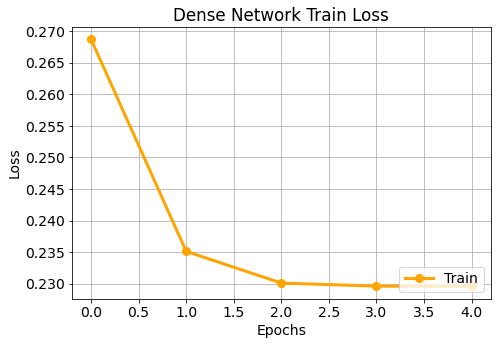

Auto select gpus: [0]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Creating measurements path...
Running on Colab
Initializing trainer...


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
mape-T (degC)-accum_epoch   0.9999366998672485
mape-p (mbar)-accum_epoch   30.347576141357422
 mape-rh (%)-accum_epoch    0.9999827146530151
mape-wv (m/s)-accum_epoch   0.9994704723358154
mse-T (degC)-accum_epoch    0.3045695126056671
mse-p (mbar)-accum_epoch    0.0264256801456213
 mse-rh (%)-accum_epoch     0.4567578434944153
mse-wv (m/s)-accum_epoch   0.048200856894254684
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


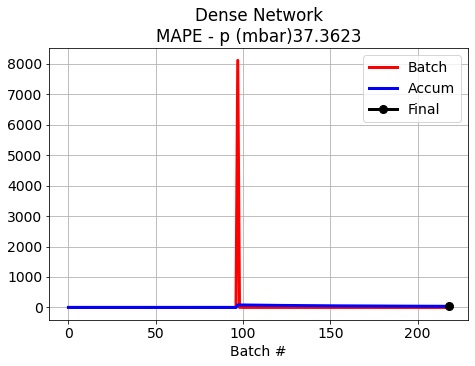

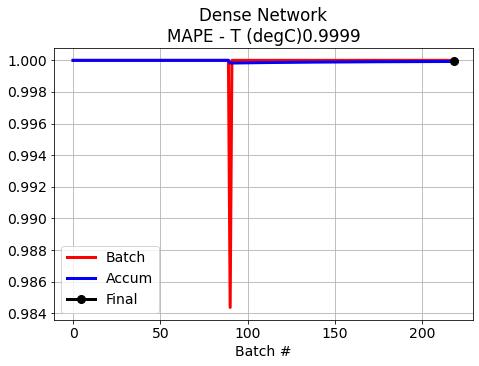

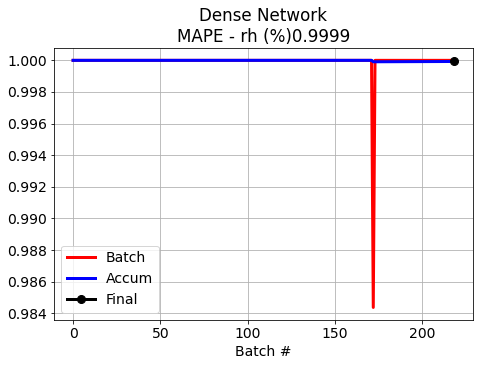

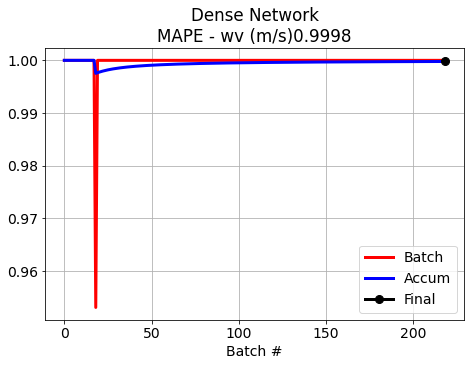

In [ ]:
# case = "Validate"
case = "Test"

p = .05
lr = .001
num_input = k * len(input_features)
num_output = len(output_features)





model_1 = DenseNetwork([num_input, round(num_input/2), round(num_input/4), num_output], torch.nn.ReLU(), loss_function, output_features, p=p, learning_rate=lr)
train_dataset = WeatherDatasetFlatten(train_csv_path, input_features, output_features, k)

train_dataset, val_dataset = split_dataset(train_dataset, train_split)

if case == 'Validatate':
	train_dataset, val_dataset = split_dataset(train_dataset, train_split)
	train_validate_model(model_1, train_dataset, val_dataset, max_epoch=max_epochs, batch_size=batch_size)
elif case == 'Test':
	train_dataset = WeatherDatasetFlatten(train_csv_path, input_features, output_features, k)
	test_dataset_base = WeatherDatasetFlatten(test_csv_path, input_features, output_features, k)
	train_model(model_1, train_dataset, max_epoch=max_epochs, batch_size=batch_size)
	test_model(model_1, test_dataset_base, max_epoch=max_epochs, batch_size=batch_size, output_features=output_features)


## LSTM Regression Network

Auto select gpus: [0]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:608: UserWarning: Checkpoint directory /content/DictLogger/0.1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                        | Params
-----------------------------------------------------------
0 | mape_feat0 | MeanAbsolutePercentageError | 0     
1 | mape_feat1 | MeanAbsolutePercentageError | 0     
2 | mape_fea

Creating measurements path...
Running on Colab
Initializing trainer...


Training: 0it [00:00, ?it/s]

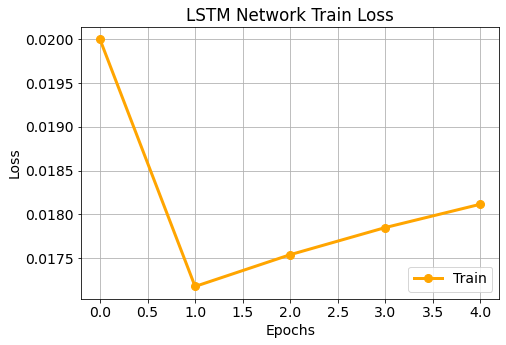

Auto select gpus: [0]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Creating measurements path...
Running on Colab
Initializing trainer...


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
mape-T (degC)-accum_epoch   26.921985626220703
mape-p (mbar)-accum_epoch    37.24946975708008
 mape-rh (%)-accum_epoch     9.491755485534668
mape-wv (m/s)-accum_epoch    65.49360656738281
mse-T (degC)-accum_epoch   0.025181064382195473
mse-p (mbar)-accum_epoch   0.045378927141427994
 mse-rh (%)-accum_epoch     0.04962271451950073
mse-wv (m/s)-accum_epoch   0.018122758716344833
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


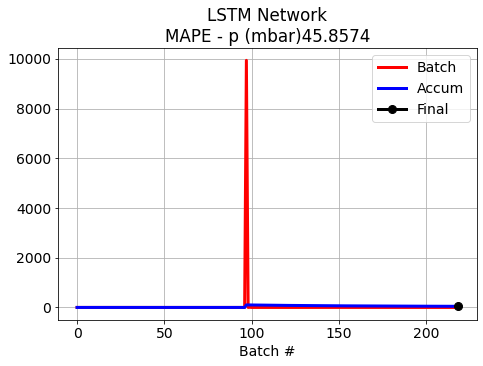

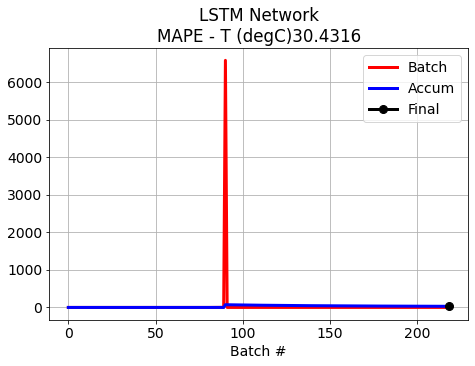

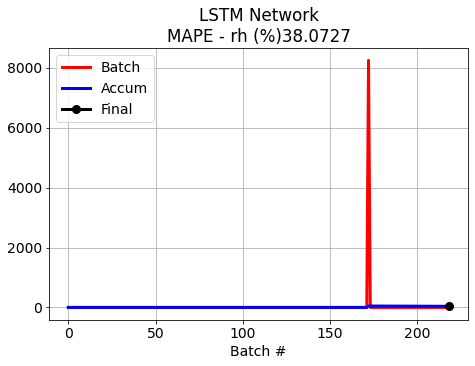

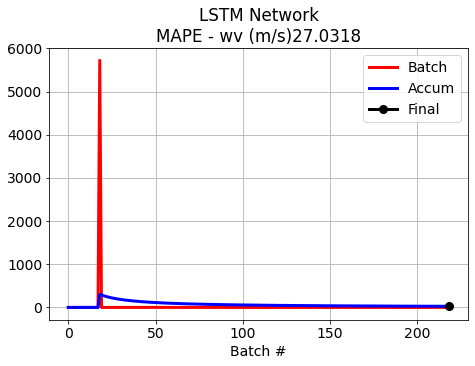

In [ ]:
case = "Test"
# case = "Test"

lr = .001
weight_decay = 1e-5
dropout = .2
hidden_size = 100

num_input = len(input_features)
num_output = len(output_features)

model_2 = LSTMNetwork(num_input, num_output, hidden_size, k, dropout, lr, weight_decay, loss_function, output_features)
train_dataset = WeatherDataset(train_csv_path, input_features, output_features, k)

if case == "Validate":
	train_dataset, val_dataset = split_dataset(train_dataset, train_split)
	train_validate_model(model_2, train_dataset, val_dataset, max_epoch=max_epochs, batch_size=batch_size)
elif case == "Test":
	train_dataset = WeatherDataset(train_csv_path, input_features, output_features, k)
	test_dataset_lstm = WeatherDataset(test_csv_path, input_features, output_features, k)
	train_model(model_2, train_dataset, max_epoch=max_epochs, batch_size=batch_size)
	test_model(model_2, test_dataset_lstm, max_epoch=max_epochs, batch_size=batch_size, output_features=output_features)

## Transformer Encoder Network

Auto select gpus: [0]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:608: UserWarning: Checkpoint directory /content/DictLogger/0.1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                | Type                        | Params
---------------------------------------------------------------------
0  | mape_feat0          | MeanAbsolutePercentageError | 0     
1  | mape_feat1          | MeanAbsol

Creating measurements path...
Running on Colab
Initializing trainer...


Training: 0it [00:00, ?it/s]

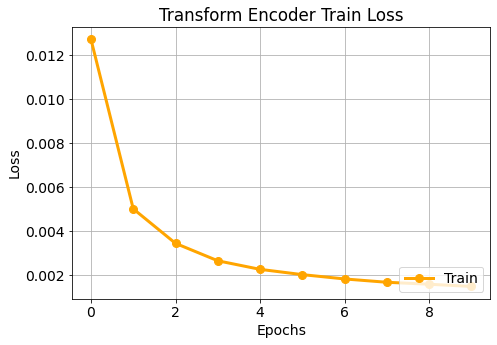

Auto select gpus: [0]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Creating measurements path...
Running on Colab
Initializing trainer...


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
mape-T (degC)-accum_epoch    9.093289375305176
mape-p (mbar)-accum_epoch   17.666427612304688
 mape-rh (%)-accum_epoch    3.1532540321350098
mape-wv (m/s)-accum_epoch   30.463960647583008
mse-T (degC)-accum_epoch   0.0018967451760545373
mse-p (mbar)-accum_epoch   0.002858805935829878
 mse-rh (%)-accum_epoch    0.003566751955077052
mse-wv (m/s)-accum_epoch   0.0018900084542110562
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


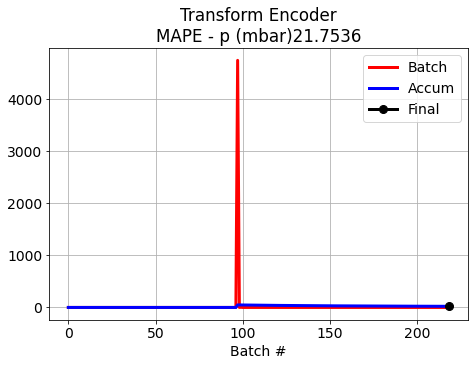

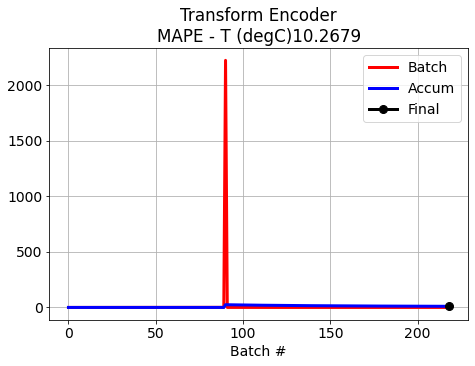

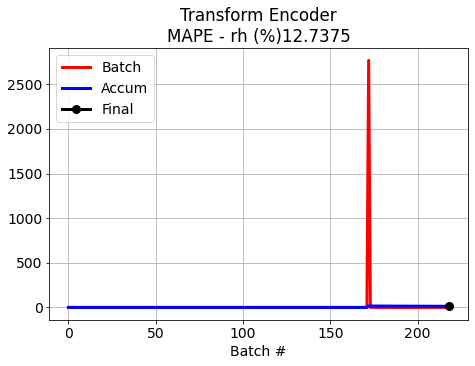

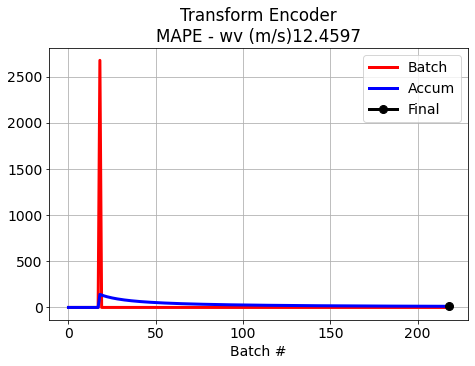

In [46]:
case = "Test"
# case = "Test"

# data params
dim_input = len(input_features)

# model design ############
pred_len = 1

k = 12
seq_len = k + 4

num_heads = len(output_features)
d_model = 32
dim_ffd = 4
ffd_layers = 2

# hyper params ###############
max_epochs = 10
learning_rate = 1e-3
weight_decay = 1e-5
dropout = 0.05

train_dataset = WeatherDatasetTransformer(train_csv_path, input_features, output_features, k, pred_len)
model_3 = TransformerEncoder(dim_input,
                           seq_len,
						   d_model,
						   num_heads,
						   ffd_layers,
						   dim_ffd,
						   dropout,
						   learning_rate,
						   weight_decay,
						   output_features)

if case == 'Validate':
	train_dataset, val_dataset = split_dataset(train_dataset, train_split)
	train_validate_model(model_3, train_dataset, val_dataset, max_epoch=max_epochs, batch_size=batch_size)

else:
	train_dataset = WeatherDatasetTransformer(train_csv_path, input_features, output_features, k, pred_len)
	test_dataset_trans = WeatherDatasetTransformer(test_csv_path, input_features, output_features, k, pred_len)
	train_model(model_3, train_dataset, max_epoch=max_epochs, batch_size=batch_size)
	test_model(model_3, test_dataset_trans, max_epoch=max_epochs, batch_size=batch_size, output_features=output_features)

# Other metrics

In [ ]:
from tabulate import tabulate

In [ ]:
# Mean absolute percentage error
def mape(y,yhat):
  ape = torch.abs((y-yhat)/y)
  ape[torch.isinf(ape)] = 1
  ape[torch.isnan(ape)] = 1
  return torch.mean(ape)  

# Weighted mean absolute persentage error
def wmape(y, yhat):
  return torch.sum(torch.abs(y-yhat)) / torch.sum(y)

# Median relative absolute error
# if our prediction is better than the benchmark, then >1

def mdrae(y, y_hat, lag = 1):
  bnchmrk = y[:-lag]
  new_y = y[lag:]
  new_yhat = y_hat[lag:]
  return torch.median(torch.abs(new_y - new_yhat)/torch.abs(new_y - bnchmrk))

def mdrae1d(y, y_hat):
  lag = 1
  bnchmrk = y[:-lag]
  new_y = y[lag:]
  new_yhat = y_hat[lag:]
  return torch.median(torch.abs(new_y - new_yhat)/torch.abs(new_y - bnchmrk))

def mdrae1y(y, y_hat):
  lag = 8760
  bnchmrk = y[:-lag]
  new_y = y[lag:]
  new_yhat = y_hat[lag:]
  return torch.median(torch.abs(new_y - new_yhat)/torch.abs(new_y - bnchmrk))

In [47]:
import numpy as np
def test_metrics(list_of_models, list_of_test_datasets, list_of_metrics):
  table = []
  graph = []  
  headers = [f.__name__ for f in list_of_metrics]

  
  fig, axes = plt.subplots(1, len(list_of_models), figsize = (8 * len(list_of_models) , 6))  

  
  for model_idx, (model,test_dataset) in enumerate(zip(list_of_models,list_of_test_datasets)):
    # First, extract the true (y) and predicted (yhat) values from the test dataset
    X = torch.stack([test_dataset[i][0] for i in range(len(test_dataset))])
    y = torch.stack([test_dataset[i][1] for i in range(len(test_dataset))])

    if model.__class__.__name__ == 'TransformerEncoder':
        X = torch.stack([test_dataset[i][0] for i in range(len(test_dataset))])
        y = torch.stack([test_dataset[i][1] for i in range(len(test_dataset))])
        y_mask = torch.stack([test_dataset[i][2] for i in range(len(test_dataset))])
        padding_mask = torch.ones((X.shape[0], X.shape[1]), dtype=bool)
        yhat = model.forward(X, padding_mask)
        masked_pred = torch.masked_select(yhat, y_mask)
        masked_seq = torch.masked_select(y, y_mask)
        y = masked_seq.reshape(X.shape[0], 4)
        yhat = masked_pred.reshape(X.shape[0], 4).detach().numpy()
    else:
      yhat = model.forward(X).detach().numpy()
    

    row = [
           model.__class__.__name__,
           '-','-','-','-'
    ]
    table.append(row)
    # Second, compute relevant metrics
    for i in range(4):
      row = [i]
      for metric in list_of_metrics:
         row.append(
            metric(y[:,i],yhat[:,i])
          )
      table.append(row)
      graph.append(row[1:])

    

    x_pos = np.arange(4)      
    if isinstance(axes, np.ndarray):      
      ax = axes[model_idx] 
    else:
      ax = axes      
    
    # Create graph for up to four metrics
    rel_pos = [-0.15, -0.05, 0.05, 0.15]
    colors = 'bgrk'
    labels = headers
    for idx, pos, c, label in zip(range(4), rel_pos, colors, labels):
      ax.bar(x_pos + pos, graph[idx], color = c, width = 0.1, label = f'feature {idx}')
    ax.legend()
    ax.set_xticks(x_pos)
    ax.set_xticklabels(headers)
    
    ax.set_ylim([0,20])
    ax.set_title(model.__class__.__name__)
  
  plt.show()  
  print('\n\n\n')
  print(tabulate(table, headers = headers ))
  



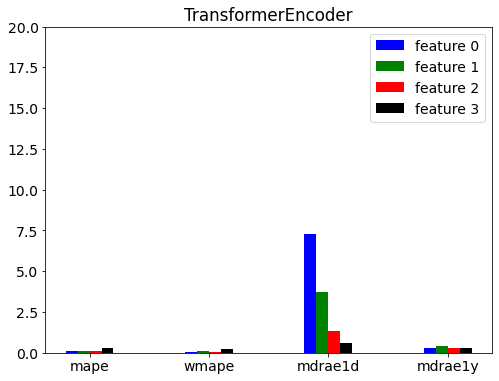





                    mape                 wmape                mdrae1d             mdrae1y
------------------  -------------------  -------------------  ------------------  -------------------
TransformerEncoder  -                    -                    -                   -
0                   0.11683747917413712  0.07328452914953232  7.307374477386475   0.26379966735839844
1                   0.1368899792432785   0.0887056514620781   3.7109344005584717  0.39901003241539
2                   0.1199076846241951   0.07789622247219086  1.3214490413665771  0.28772690892219543
3                   0.2913486957550049   0.20712323486804962  0.599746584892273   0.3011859357357025


In [48]:
test_metrics([ model_3], [test_dataset_trans],[mape, wmape, mdrae1d, mdrae1y])

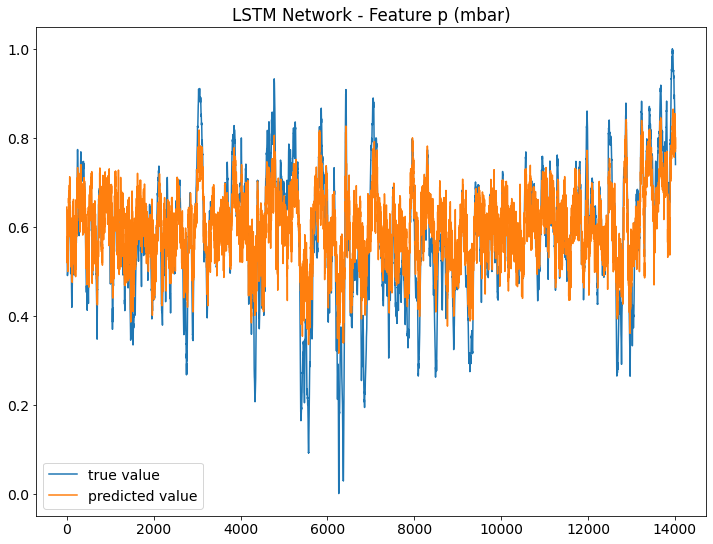

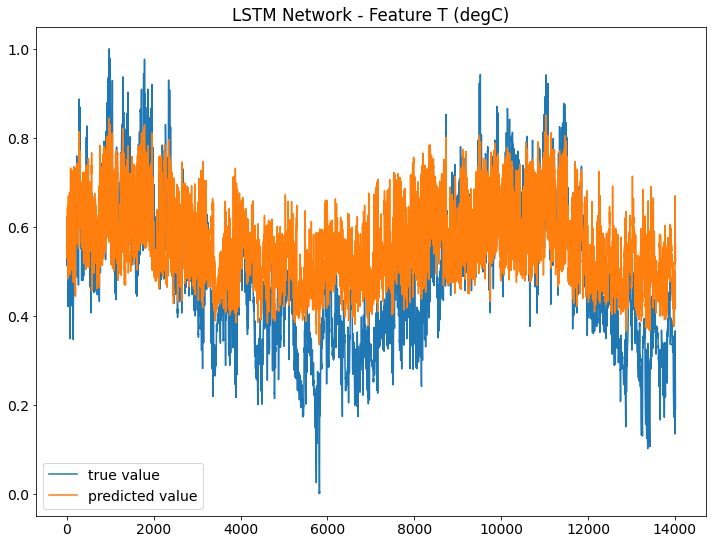

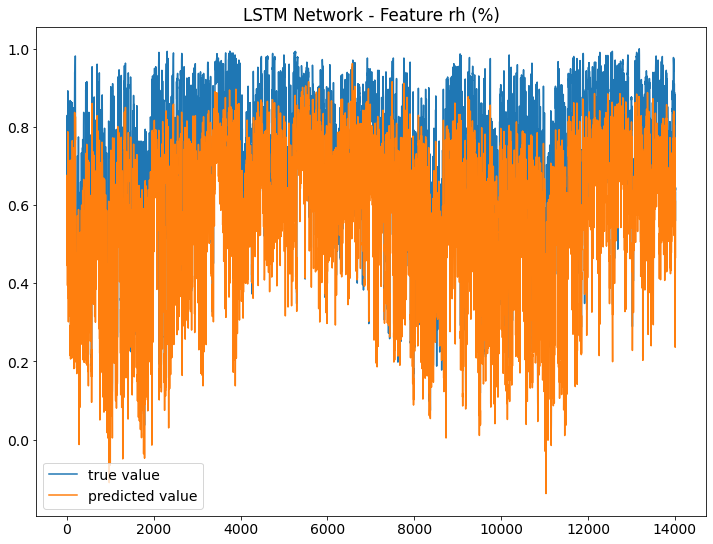

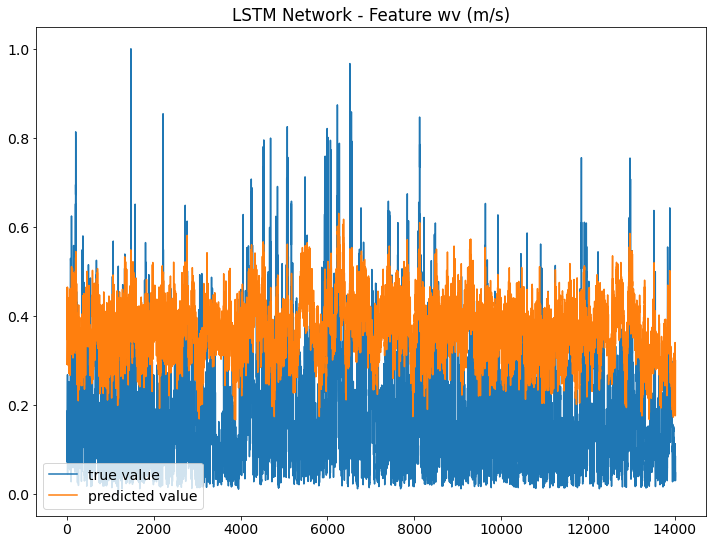

In [ ]:
for i in range(4):
  plt.figure(figsize= (12,9))
  plt.plot(y[:,i], label = 'true value')  
  plt.plot(yhat[:,i], label = 'predicted value')
  plt.title(f'{model.name} - Feature {output_features[i]}')
  plt.legend(loc = 'lower left')